In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from pathlib import Path
from torch.utils.data import DataLoader

from torchfitter.trainer import Trainer
from torchfitter.utils import DataWrapper
from torchfitter.regularization import L1Regularization

from sklearn.model_selection import train_test_split

torch.manual_seed(0)
np.random.seed(0)

In [3]:
DATA_PATH = Path(os.path.abspath('')).parent / "tests/data"

In [4]:
X = np.load(DATA_PATH / "features.npy")
y = np.load(DATA_PATH / "labels.npy")

y = y.reshape(-1,1)

In [5]:
# simplest case of cross-validation
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=0.33, 
    random_state=42
)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
model = nn.Linear(in_features=1, out_features=1)
model.to(device)

regularizer = L1Regularization(regularization_rate=0.01, biases=False)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [8]:
from torchfitter.callbacks import LoggerCallback, EarlyStopping, LearningRateScheduler

In [9]:
callbacks = [
    LoggerCallback(update_step=100),
    EarlyStopping(patience=100, load_best=True),
    LearningRateScheduler(
        scheduler=optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)
    )
]

In [10]:
trainer = Trainer(
    model=model, 
    criterion=criterion,
    optimizer=optimizer, 
    regularizer=None, # regularizer
    device=device,
    callbacks=callbacks
)

In [11]:
# wrap data in Dataset
train_wrapper = DataWrapper(
    X_train, 
    y_train, 
    dtype_X='float', 
    dtype_y='float'
)
val_wrapper = DataWrapper(X_val, y_val, dtype_X='float', dtype_y='float')

# torch Loaders
train_loader = DataLoader(train_wrapper, batch_size=32, pin_memory=True)
val_loader = DataLoader(val_wrapper, batch_size=32, pin_memory=True)

In [12]:
# fitting process
trainer.fit(train_loader, val_loader, epochs=2000)

INFO:root:Starting training process on cuda


  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:Epoch: 1/2000     | Train loss: 8425.839658   | Validation loss: 8646.116477   | Time/epoch: 0.354590     
INFO:root:Epoch: 100/2000     | Train loss: 6681.455218   | Validation loss: 6886.093350   | Time/epoch: 0.047430     
INFO:root:Epoch: 200/2000     | Train loss: 5186.798851   | Validation loss: 5367.922918   | Time/epoch: 0.055990     
INFO:root:Epoch: 300/2000     | Train loss: 3960.719448   | Validation loss: 4117.459872   | Time/epoch: 0.058860     
INFO:root:Epoch: 400/2000     | Train loss: 2963.304478   | Validation loss: 3096.008046   | Time/epoch: 0.055000     
INFO:root:Epoch: 500/2000     | Train loss: 2122.722720   | Validation loss: 2232.139859   | Time/epoch: 0.056000     
INFO:root:Epoch: 600/2000     | Train loss: 1494.413016   | Validation loss: 1584.052551   | Time/epoch: 0.048480     
INFO:root:Epoch: 700/2000     | Train loss: 990.168823    | Validation loss: 1060.766141   | Time/epoch: 0.056000     
INFO:root:Epoch: 800/2000     | Train loss: 621.67

In [13]:
# predictions
with torch.no_grad():
    y_pred = model(torch.from_numpy(X_val).float().to(device)).cpu().numpy()

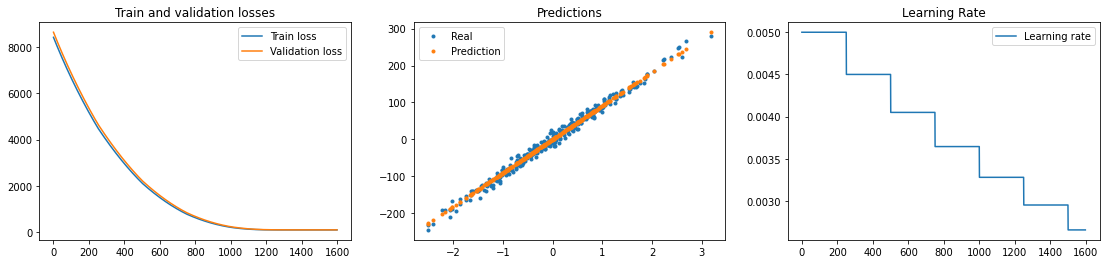

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(19,4))

ax[0].plot(trainer.params_dict['history']['train_loss'], label='Train loss')
ax[0].plot(trainer.params_dict['history']['validation_loss'], label='Validation loss')
ax[0].set_title('Train and validation losses')
ax[0].legend();

ax[1].plot(X_val, y_val, '.', label="Real")
ax[1].plot(X_val, y_pred, '.', label="Prediction")
ax[1].set_title('Predictions')
ax[1].legend();


ax[2].plot(trainer.params_dict['history']['learning_rate'], label="Learning rate")
ax[2].set_title('Learning Rate')
ax[2].legend();